In [1]:
import os

# Use only 1 GPU if available
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chronos import BaseChronosPipeline, Chronos2Pipeline

# Load the Chronos-2 pipeline
# GPU recommended for faster inference, but CPU is also supported
pipeline: Chronos2Pipeline = BaseChronosPipeline.from_pretrained("amazon/chronos-2", device_map="cuda")

/home/nurzhan/Projects/chronos-kickstart/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* defined Chronos-2 pipeline

In [27]:
target = 'target'
prediction_length = 24
id_column = 'item_id'
timestamp_column = 'timestamp'
timeseries_id = 'T000000'

data = pd.read_csv("../data/elect_test.csv")
data = data[data[id_column] == timeseries_id]

data[timestamp_column] = pd.to_datetime(data[timestamp_column])
data = data.sort_values(timestamp_column)

context_df = data.iloc[:-prediction_length]
test_df = data.iloc[-prediction_length:]
future_df = test_df.drop(columns=target)

print("Full dataframe shape: ", data.shape)

print("Input dataframe shape: ", context_df.shape)
display(context_df.head())

print("Test dataframe shape: ", test_df.shape)
display(test_df.head())

print("Future dataframe shape: ", future_df.shape)
display(future_df.head())

Full dataframe shape:  (34608, 3)
Input dataframe shape:  (34584, 3)


,item_id,timestamp,target
0,T000000,2013-03-10 00:00:00,5207.959961
1,T000000,2013-03-10 00:30:00,5002.275879
2,T000000,2013-03-10 01:00:00,4747.569824
3,T000000,2013-03-10 01:30:00,4544.880859
4,T000000,2013-03-10 02:00:00,4425.952148


Test dataframe shape:  (24, 3)


,item_id,timestamp,target
172824,T000000,2015-02-28 12:00:00,6508.676758
172825,T000000,2015-02-28 12:30:00,6570.471191
172826,T000000,2015-02-28 13:00:00,6660.939941
172827,T000000,2015-02-28 13:30:00,6772.914551
172828,T000000,2015-02-28 14:00:00,6867.194336


Future dataframe shape:  (24, 2)


,item_id,timestamp
172824,T000000,2015-02-28 12:00:00
172825,T000000,2015-02-28 12:30:00
172826,T000000,2015-02-28 13:00:00
172827,T000000,2015-02-28 13:30:00
172828,T000000,2015-02-28 14:00:00


In [28]:
pred_df = pipeline.predict_df(
    context_df,
    future_df=future_df,
    prediction_length=prediction_length,
    quantile_levels=[0.1, 0.5, 0.9],
    timestamp_column=timestamp_column,
    target=target,
)

In [29]:
pred_df.head()

,item_id,timestamp,target_name,predictions,0.1,0.5,0.9
0,T000000,2015-02-28 12:00:00,target,6449.268066,6403.348145,6449.268066,6525.447266
1,T000000,2015-02-28 12:30:00,target,6465.280762,6406.208984,6465.280762,6578.649414
2,T000000,2015-02-28 13:00:00,target,6491.016113,6400.816895,6491.016113,6621.569824
3,T000000,2015-02-28 13:30:00,target,6508.067871,6413.020996,6508.067871,6693.333496
4,T000000,2015-02-28 14:00:00,target,6555.260742,6441.264160,6555.260742,6759.784668


In [30]:
def plot_forecast(
    context_df: pd.DataFrame,
    pred_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_column: str,
    timeseries_id: str,
    id_column: str,
    timestamp_column: str = "timestamp",
    history_length: int = 256,
    title_suffix: str = "",
):
    ts_context = context_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]
    ts_pred = pred_df.query(f"{id_column} == @timeseries_id and target_name == @target_column").set_index(
        timestamp_column
    )[["0.1", "predictions", "0.9"]]
    ts_ground_truth = test_df.query(f"{id_column} == @timeseries_id").set_index(timestamp_column)[target_column]

    last_date = ts_context.index.max()
    start_idx = max(0, len(ts_context) - history_length)
    plot_cutoff = ts_context.index[start_idx]
    ts_context = ts_context[ts_context.index >= plot_cutoff]
    ts_pred = ts_pred[ts_pred.index >= plot_cutoff]
    ts_ground_truth = ts_ground_truth[ts_ground_truth.index >= plot_cutoff]

    fig = plt.figure(figsize=(12, 3))
    ax = fig.gca()
    ts_context.plot(ax=ax, label=f"historical {target_column}", color="xkcd:azure")
    ts_ground_truth.plot(ax=ax, label=f"future {target_column} (ground truth)", color="xkcd:grass green")
    ts_pred["predictions"].plot(ax=ax, label="forecast", color="xkcd:violet")
    ax.fill_between(
        ts_pred.index,
        ts_pred["0.1"],
        ts_pred["0.9"],
        alpha=0.7,
        label="prediction interval",
        color="xkcd:light lavender",
    )
    ax.axvline(x=last_date, color="black", linestyle="--", alpha=0.5)
    ax.legend(loc="upper left")
    ax.set_title(f"{target_column} forecast for {timeseries_id} {title_suffix}")
    fig.show()

/tmp/ipykernel_69977/3393198218.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


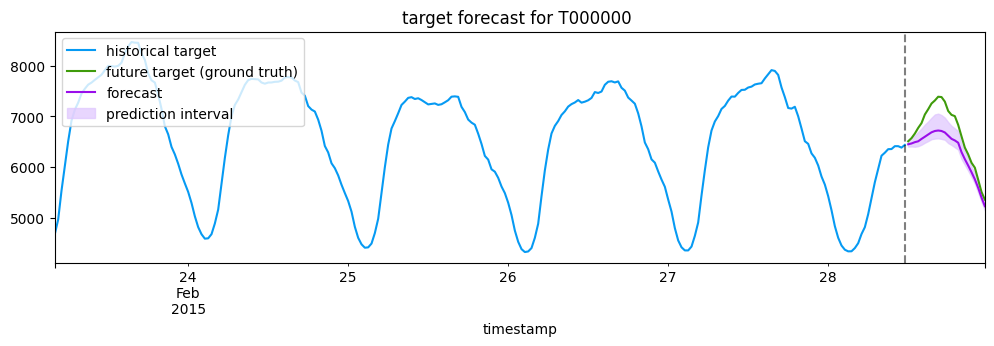

In [31]:
# Visualize forecast with covariates
plot_forecast(
    context_df=context_df,
    pred_df=pred_df,
    test_df=test_df,
    target_column=target,
    id_column=id_column,
    timeseries_id=timeseries_id
)